# Импортируем библиотеки

In [41]:
import pandas as pd 

from sklearn.model_selection import train_test_split  # Загружаем специальный инструмент для разбивки
import re # Расчехлим регулярки
import geocoder
import seaborn as sns
import collections
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup as bs
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Пакет работы с языком
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

# LightAutoML задачи и генерация модели
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\saakyan.ag\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Начальные установки и импорт данных

## КАКОЙ КЕЙС РЕШАЕМ?

### **Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.**

Первоначальная версия датасета содержит 17 полей со следующей информацией:


* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

In [42]:
N_THREADS = 8
N_FOLDS = 5
RANDOM_STATE = 314159
TEST_SIZE = 0.2
TIMEOUT = 2400
TARGET_NAME = 'reviewer_score'

In [43]:
train_data = pd.read_csv('data\hotels_train.csv')
train_data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [44]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [45]:
# Загрузим данные для предсказания
test_data = pd.read_csv('data\hotels_test.csv')

## Заберем сторонние данные

**Скорее всего, на рейтинг и мнение людей влияют общие экономические глобальные показатели.**

**Возьмем для отражения таких показателей индекс Джини, данные по ВВП и населению, коэфициент алертности.**

In [46]:
# Засосем данные по индексу Джини
gdp = pd.read_excel('https://api.worldbank.org/v2/en/indicator/NY.GDP.MKTP.CD?downloadformat=excel',header=3)

# Отбросим лишние данные и преобразуем в словарь
cols_to_drop = list(gdp.columns)
cols_to_drop.remove('2020')
gdp.index = gdp['Country Name']
gdp.drop(cols_to_drop,axis=1,inplace=True)
gdp = gdp.to_dict(orient='index')

gdp

{'Aruba': {'2020': nan},
 'Africa Eastern and Southern': {'2020': 920792331527.7456},
 'Afghanistan': {'2020': 20116137325.820553},
 'Africa Western and Central': {'2020': 784587603322.8662},
 'Angola': {'2020': 58375976292.96779},
 'Albania': {'2020': 14887629268.292683},
 'Andorra': {'2020': nan},
 'Arab World': {'2020': 2447584445275.5156},
 'United Arab Emirates': {'2020': 358868765174.92444},
 'Argentina': {'2020': 389288056265.3253},
 'Armenia': {'2020': 12641209802.111986},
 'American Samoa': {'2020': 709000000.0},
 'Antigua and Barbuda': {'2020': 1370281481.4814813},
 'Australia': {'2020': 1327836171068.5078},
 'Austria': {'2020': 433258467676.51483},
 'Azerbaijan': {'2020': 42607176470.588234},
 'Burundi': {'2020': 2841786382.1906333},
 'Belgium': {'2020': 521861292586.6162},
 'Benin': {'2020': 15651545331.540379},
 'Burkina Faso': {'2020': 17933606353.177456},
 'Bangladesh': {'2020': 323056957972.31177},
 'Bulgaria': {'2020': 69889347433.43239},
 'Bahrain': {'2020': 347292287

In [47]:
# Найдем данные об индексе Джини и населению стран
url = 'https://worldpopulationreview.com/country-rankings/gini-coefficient-by-country'
page = requests.get(url)

soup = bs(page.content, 'html.parser')
tbl = soup.find("table")

gini_index = pd.read_html(str(tbl))[0]

gini_index

,Country,Gini % - World Bank,Data Year (World Bank),Gini % - CIA World Factbook,Data Year (CIA),2022 Population
0,South Africa,63.0,2014.0,63.0,2014.0,60756135
1,Namibia,59.1,2015.0,59.1,2015.0,2633874
2,Suriname,57.9,1999.0,NaN,NaN,596831
3,Zambia,57.1,2015.0,57.1,2015.0,19470234
4,Sao Tome And Principe,56.3,2017.0,56.3,2017.0,227679
...,...,...,...,...,...,...
171,Hong Kong,NaN,NaN,53.9,2016.0,7604299
172,Cambodia,NaN,NaN,37.9,2008.0,17168639
173,Taiwan,NaN,NaN,33.6,2014.0,23888595
174,Saudi Arabia,NaN,NaN,45.9,2013.0,35844909


In [48]:

# Отделим лишнее и преобразуем в словарь для быстрого доступа
gini_index.index = gini_index['Country']
gini_index.drop(['Country','Data Year (World Bank)','Gini % - CIA World Factbook','Data Year (CIA)'],axis=1,inplace=True)
gini_index = gini_index.to_dict(orient='index')

gini_index

{'South Africa': {'Gini % - World Bank': 63.0, '2022 Population': 60756135},
 'Namibia': {'Gini % - World Bank': 59.1, '2022 Population': 2633874},
 'Suriname': {'Gini % - World Bank': 57.9, '2022 Population': 596831},
 'Zambia': {'Gini % - World Bank': 57.1, '2022 Population': 19470234},
 'Sao Tome And Principe': {'Gini % - World Bank': 56.3,
  '2022 Population': 227679},
 'Central African Republic': {'Gini % - World Bank': 56.2,
  '2022 Population': 5016678},
 'Eswatini': {'Gini % - World Bank': 54.6, '2022 Population': 1184817},
 'Mozambique': {'Gini % - World Bank': 54.0, '2022 Population': 33089461},
 'Brazil': {'Gini % - World Bank': 53.4, '2022 Population': 215353593},
 'Belize': {'Gini % - World Bank': 53.3, '2022 Population': 412190},
 'Botswana': {'Gini % - World Bank': 53.3, '2022 Population': 2441162},
 'Angola': {'Gini % - World Bank': 51.3, '2022 Population': 35027343},
 'Colombia': {'Gini % - World Bank': 51.3, '2022 Population': 51512762},
 'Saint Lucia': {'Gini % - Wor

In [49]:
# Найдем показатель алертности
alert_index = pd.read_excel('data/fsi-2017.xlsx')

alert_index = alert_index[['Country','Total']]

alert_index

,Country,Total
0,South Sudan,113.9
1,Somalia,113.4
2,Central African Republic,112.6
3,Yemen,111.1
4,Sudan,110.6
...,...,...
173,Sweden,22.1
174,Denmark,21.5
175,Switzerland,21.1
176,Norway,20.5


# Обработаем данные, выделим дополнительные признаки и приведем данные к числовым показателям

In [50]:
# Уберем дубликаты

train_data.drop_duplicates(inplace=True,ignore_index=True)

In [51]:
# Для обработки, соберем все в один DataFrame

train_data['sample'] = 1
train_data['id'] = train_data.index
test_data['sample'] = 0
test_data[TARGET_NAME] = 0
test_data['id'] = test_data.index
df = train_data.copy()
df = pd.concat([train_data,test_data],axis=0,ignore_index=True)

df.shape

(515431, 19)

In [52]:
%%time

def create_expert_feats(data):
    """Метод добавления, очистки и подготовки признаков.

    Args:
        data (pd.DataFrame): входной DataFrame

    Returns:
        pd.DataFrame: обработанный DataFrame
    """
    # Получим список адресов отелей с координатами
    h_df = data[['hotel_address','lat','lng']].groupby(by=['hotel_address'],as_index=True).mean()

    # Доопределим координаты отоелей

    for i in h_df[h_df['lat'].isnull()].index:
        g =geocoder.arcgis(i) # Запрос координат через модуль geocoder
        h_df.at[i,'lat'] = g.latlng[0]
        h_df.at[i,'lng'] = g.latlng[1]

    # Разберем адрес на страну и город
    h_df['country'] = ''
    
    h_df['addres'] = h_df.index
    h_df['country'] = h_df['addres'].apply(lambda x: x.split(' ')[-1] if (x.split(' ')[-1] != 'Kingdom') else (x.split(' ')[-2]+' '+x.split(' ')[-1]))

    # Преобразуем в словарь для удобства доступа
    latlng_dict = h_df.to_dict(orient='index')
    
    # Определим входящие в сеть отели
    data['hotel_net'] = data['hotel_name'].apply(
    lambda x: re.search(r'Mercure|Golden Tulip|Holiday Inn|Golden Tulip|Radisson|Best Western|DoubleTree',x)[0] \
        if (re.search(r'Mercure|Golden Tulip|Holiday Inn|Golden Tulip|Radisson|Best Western|DoubleTree',x) is not None) \
    else 'Not_in_net'
    )
    
    # Дооперелеим страну и город
    data['country'] = ''
    data['country'] = data['hotel_address'].apply(lambda x: x.split(' ')[-1] if (x.split(' ')[-1] != 'Kingdom') else (x.split(' ')[-2]+' '+x.split(' ')[-1]))

    # Получим данные из закаченных источников по индексу Джини, популяции и ВВП для стран с отелем
    data['hc_gini'] = data['country'].apply(lambda x: gini_index[x]['Gini % - World Bank'])
    data['hc_population'] = data['country'].apply(lambda x: gini_index[x]['2022 Population'])
    data['hc_gdp'] = data['country'].apply(lambda x: gdp.get(x)['2020'] if gdp.get(x) is not None else 0)

    # Поправим представление данных о национальности, оно имеет пробелы в конце и начале
    data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x[1:-1])
    
    # Добавим alert_index:
    data = data.merge(alert_index, how='left', left_on='country', right_on='Country')                    ####  !!!!
    data = data.merge(alert_index, how='left', left_on='reviewer_nationality', right_on='Country',suffixes=('_ha','_ra'))     ####  !!!!
    data.drop(['Country_ra','Country_ha'],axis=1,inplace=True)
    
    data.fillna(0,inplace=True)

    # Поправим данные об Америке
    us_list = ['Jersey','United States of America']
    data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: 'United States' if x in us_list else x)

    # Получим данные из закаченных источников по индексу Джини, популяции и ВВП для стран ревьюера
    data['rc_gini'] = data['reviewer_nationality'].apply(lambda x: gini_index.get(x)['Gini % - World Bank'] if gini_index.get(x) is not None else 0)
    data['rc_population'] = data['reviewer_nationality'].apply(lambda x: gini_index.get(x)['2022 Population'] if gini_index.get(x) is not None else 0)
    data['rc_gdp'] = data['reviewer_nationality'].apply(lambda x: gdp.get(x)['2020'] if gdp.get(x) is not None else 0)
    
    # Дозапоним индексы Джини медианным значением
    data['rc_gini'].fillna(data['rc_gini'].median(),inplace=True)
    data['rc_gdp'].fillna(data['rc_gdp'].median(),inplace=True)

    # Заполним координаты в главном DataFrame'е
    for i in data[data['lat'].isnull()].index:
        data.at[i,'lat'] = latlng_dict[data['hotel_address'][i]]['lat']
        data.at[i,'lng'] = latlng_dict[data['hotel_address'][i]]['lng']
    
    # Приведем столбец days_since_review в int
    data['days_since_review'] = data['days_since_review'].apply(lambda x: re.search(r'\d+', x)[0])
    data['days_since_review'] = data['days_since_review'].astype('int')
    
    # Разберем тэги
    data['tags'] = data['tags'].apply(lambda x: x.lower())
    data['tags_list'] = data['tags'].apply(lambda x: re.findall(r'\' ([\w ]+) \'', x))
    tags_list = []
    
    tags_list = []
    for i in data.index:
        for val in data['tags_list'][i]:
            tags_list.append(val)
    
    sent_analyzer = SentimentIntensityAnalyzer()
    
    tags_cnt = collections.Counter(tags_list)
    top_tags_set = set([key for key, _ in tags_cnt.most_common(10)])
    
    data['tags'] = data['tags_list'].apply(lambda x: '|'.join(sorted(list(top_tags_set.intersection(set(x))))))
    
    # Анализируем отзывы
    data['rw_neg'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
    data['rw_pos'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)) 
    
    data.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(data['rw_neg'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
    data.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(data['rw_pos'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
    
    # Разберем негативные комменты
    data['negative_review'] = data['negative_review'].apply(lambda x: x.lower())
    data['negative_rev_words_list'] = data['negative_review'].apply(lambda x: x.split(' '))
    negative_rev_words_list = []
    for i in data.index:
        for val in data['negative_rev_words_list'][i]:
            negative_rev_words_list.append(val)  
              
    negative_rev_words_cnt = collections.Counter(negative_rev_words_list)
    top_negative_rev_words_set = set([key for key, _ in negative_rev_words_cnt.most_common(5)])
    
    data['negative_rev_words_list'] = data['negative_rev_words_list'].apply(lambda x: '|'.join(sorted(list(top_negative_rev_words_set.intersection(set(x))))))
    
    # Разберем позитивные комменты
    data['positive_review'] = data['positive_review'].apply(lambda x: x.lower())
    data['positive_rev_words_list'] = data['positive_review'].apply(lambda x: x.split(' '))
    positive_rev_words_list = []
    for i in data.index:
        for val in data['positive_rev_words_list'][i]:
            positive_rev_words_list.append(val)  
              
    positive_rev_words_cnt = collections.Counter(positive_rev_words_list)
    top_positive_rev_words_set = set([key for key, _ in positive_rev_words_cnt.most_common(5)])
    
    data['positive_rev_words_list'] = data['positive_rev_words_list'].apply(lambda x: '|'.join(sorted(list(top_positive_rev_words_set.intersection(set(x))))))
    
    # Разберемся со столбцом национальности ревьюера
    rnat_list = []

    for i in data.index:
        rnat_list.append(data['reviewer_nationality'][i]) 
        
    rnat_cnt = collections.Counter(rnat_list)
    top_rnat_set = set([key for key, _ in rnat_cnt.most_common(5)])
    
    data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in top_rnat_set else 'other')    
    
    to_ordenc_list = ['reviewer_nationality','country','positive_rev_words_list','negative_rev_words_list','tags','hotel_net']
    enc = OrdinalEncoder()
    enc.fit(data[to_ordenc_list])
    data[to_ordenc_list] = enc.transform(data[to_ordenc_list])

    data['neg_len'] = data['negative_review'].map(len)
    data['pos_len'] = data['positive_review'].map(len)

    # Выведем процентное содержание позитивных и негативных слов
    data['positive_word_per'] = 100 * data['review_total_positive_word_counts'] / (data['review_total_negative_word_counts'] + data['review_total_positive_word_counts'])
    data['negative_word_per'] = 100 * data['review_total_negative_word_counts'] / (data['review_total_negative_word_counts'] + data['review_total_positive_word_counts'])
    data['#_pos_words'] = data['review_total_positive_word_counts'] / data['total_number_of_reviews_reviewer_has_given']
    data['#_neg_words'] = data['review_total_negative_word_counts'] / data['total_number_of_reviews_reviewer_has_given']
    data['pos_rev_rate'] = data['review_total_positive_word_counts'] / data['total_number_of_reviews']
    data['neg_rev_rate'] = data['review_total_negative_word_counts'] / data['total_number_of_reviews']
    data['positive_word_per'].fillna(0,inplace=True)
    data['negative_word_per'].fillna(0,inplace=True)
    data['add_pos_rate'] = data['review_total_positive_word_counts'] / data['additional_number_of_scoring']
    data['add_neg_rate'] = data['review_total_negative_word_counts'] / data['total_number_of_reviews']
    
    data['review_rate'] = data['total_number_of_reviews_reviewer_has_given'] / data['total_number_of_reviews']

        
    # Разберем дату на признаки
    data['review_date'] = pd.to_datetime(data['review_date'])
    
    data['year'] = data['review_date'].dt.year
    data['month'] = data['review_date'].dt.month
    data['day'] = data['review_date'].dt.day
    data['dayofweek'] = data['review_date'].dt.dayofweek

    # Убираем лишние столбцы в виде дат и типа odject
    data.drop('review_date', axis = 1, inplace=True)
    
    object_columns = [s for s in data.columns if data[s].dtypes == 'object']
    data.drop(object_columns, axis = 1, inplace=True)

    return data

#train_data = create_expert_feats(train_data)
#test_data = create_expert_feats(test_data)
df = create_expert_feats(df)

Wall time: 4min 11s


In [53]:
#df.fillna(0,inplace=True)

## Посмотрим, как выглядит результирующий DataFrame

In [54]:
df.shape

(515431, 49)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515431 entries, 0 to 515430
Data columns (total 49 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   reviewer_nationality                        515431 non-null  float64
 3   review_total_negative_word_counts           515431 non-null  int64  
 4   total_number_of_reviews                     515431 non-null  int64  
 5   review_total_positive_word_counts           515431 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 7   reviewer_score                              515431 non-null  float64
 8   tags                                        515431 non-null  float64
 9   days_since_review                           515431 non-null  int32  
 

In [56]:
# Разделим данные обратно на данные для обучения и данные для предсказания

train_data = df[df['sample'] == 1]
test_data = df[df['sample'] == 0]
train_data.index = train_data['id']
test_data.index = test_data['id']

train_data.drop(['sample','id'],axis=1,inplace=True)
test_data.drop(['sample','id',TARGET_NAME],axis=1,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [57]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386495
Data columns (total 47 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386496 non-null  int64  
 1   average_score                               386496 non-null  float64
 2   reviewer_nationality                        386496 non-null  float64
 3   review_total_negative_word_counts           386496 non-null  int64  
 4   total_number_of_reviews                     386496 non-null  int64  
 5   review_total_positive_word_counts           386496 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  386496 non-null  int64  
 7   reviewer_score                              386496 non-null  float64
 8   tags                                        386496 non-null  float64
 9   days_since_review                           386496 non-null  int32  
 

# Посмотрим, как влияют признаки на результат и отберем нужные

Разобьем признаки на две группы и проведем анализ.

In [58]:
# Непрерывные признаки
num_cols = ['additional_number_of_scoring', 'average_score','review_total_negative_word_counts','total_number_of_reviews',
            'review_total_positive_word_counts','total_number_of_reviews_reviewer_has_given', 'days_since_review','lat', 'lng',
             'hc_gini','hc_population', 'hc_gdp', 'rc_gini', 'rc_population', 'rc_gdp', 'n_neg', 'n_neu', 'n_pos', 'n_compound', 
             'p_neg', 'p_neu', 'p_pos', 'p_compound', 'positive_word_per', 'negative_word_per','neg_len','pos_len','#_pos_words',
             '#_neg_words','review_rate','neg_rev_rate','pos_rev_rate','add_pos_rate','add_neg_rate','Total_ha','Total_ra']

# Категориальные признаки
cat_cols = ['reviewer_nationality', 'tags', 'country', 'negative_rev_words_list','positive_rev_words_list', 'year', 'month', 'day',
            'dayofweek','hotel_net']

In [59]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = train_data.drop([TARGET_NAME], axis = 1)  
y = train_data[TARGET_NAME] 

<AxesSubplot:>

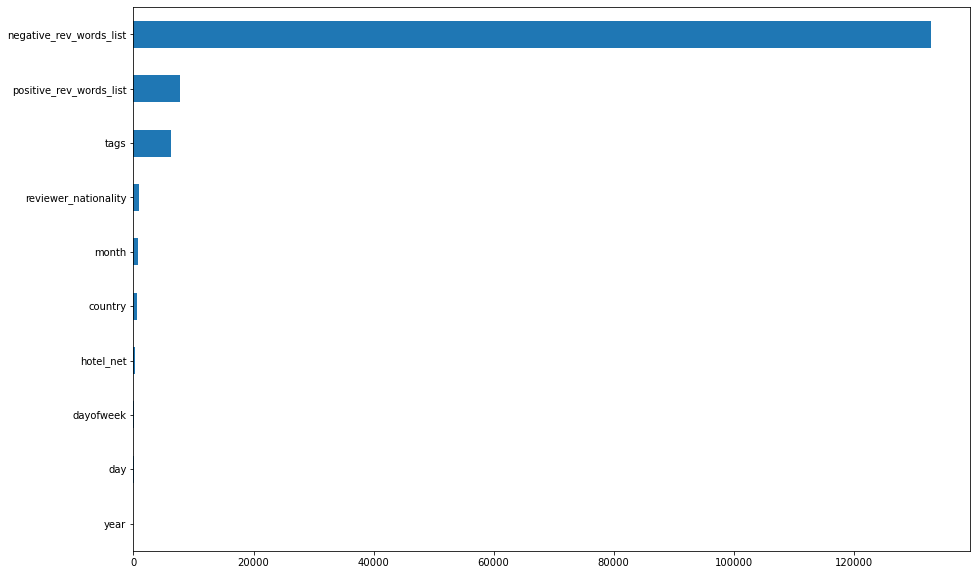

In [60]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

plt.rcParams['figure.figsize'] = (15,10)
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [61]:
# Выведем очки вклада категориальных признаков
imp_cat

year                            0.055663
day                            37.471570
dayofweek                      64.240050
hotel_net                     275.419198
country                       624.843651
month                         731.116137
reviewer_nationality          956.101051
tags                         6245.075178
positive_rev_words_list      7684.076176
negative_rev_words_list    132780.689720
dtype: float64

In [62]:
# Отберем категориальные признаки, которые дают наибольший вклад:
res_cols = [TARGET_NAME]
res_cols.extend(imp_cat[imp_cat >= 100].index)

res_cols

['reviewer_score',
 'hotel_net',
 'country',
 'month',
 'reviewer_nationality',
 'tags',
 'positive_rev_words_list',
 'negative_rev_words_list']

<AxesSubplot:>

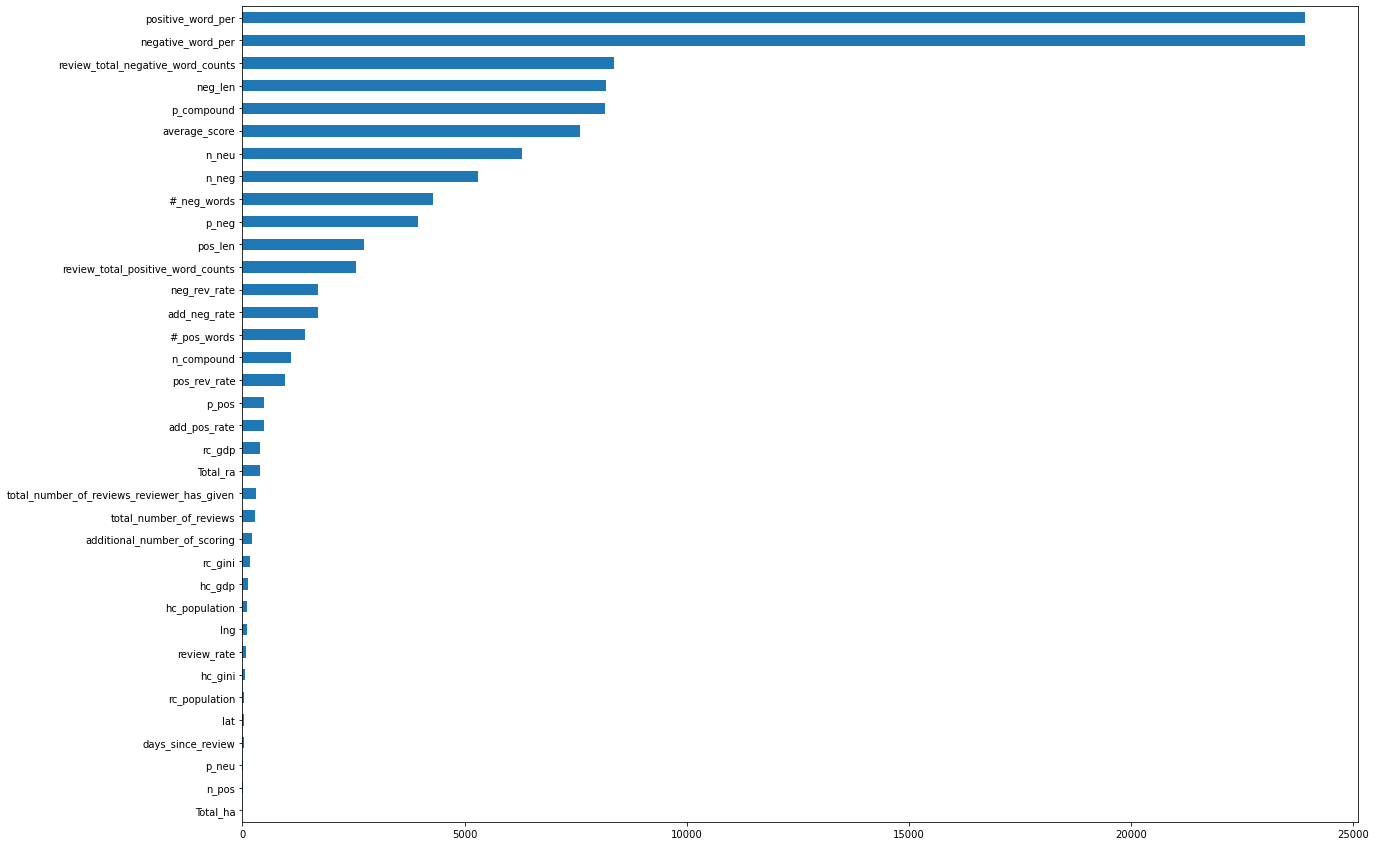

In [63]:
from sklearn.feature_selection import f_classif # anova

plt.rcParams['figure.figsize'] = (20,15)
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [64]:
# Выведем очки вклада числовых признаков
imp_num

Total_ha                                          3.225848
n_pos                                            18.546609
p_neu                                            21.321106
days_since_review                                26.722059
lat                                              31.940644
rc_population                                    42.415434
hc_gini                                          61.000537
review_rate                                      83.579671
lng                                              95.738562
hc_population                                   109.694693
hc_gdp                                          134.919535
rc_gini                                         171.169829
additional_number_of_scoring                    212.164084
total_number_of_reviews                         277.930171
total_number_of_reviews_reviewer_has_given      299.803806
Total_ra                                        388.253357
rc_gdp                                          406.3790

In [65]:
# Отберем числовые признаки, которые дают наибольший вклад:
res_cols.extend(imp_num[imp_num > 100].index)

res_cols

['reviewer_score',
 'hotel_net',
 'country',
 'month',
 'reviewer_nationality',
 'tags',
 'positive_rev_words_list',
 'negative_rev_words_list',
 'hc_population',
 'hc_gdp',
 'rc_gini',
 'additional_number_of_scoring',
 'total_number_of_reviews',
 'total_number_of_reviews_reviewer_has_given',
 'Total_ra',
 'rc_gdp',
 'add_pos_rate',
 'p_pos',
 'pos_rev_rate',
 'n_compound',
 '#_pos_words',
 'add_neg_rate',
 'neg_rev_rate',
 'review_total_positive_word_counts',
 'pos_len',
 'p_neg',
 '#_neg_words',
 'n_neg',
 'n_neu',
 'average_score',
 'p_compound',
 'neg_len',
 'review_total_negative_word_counts',
 'negative_word_per',
 'positive_word_per']

In [66]:
# Подготовим данные
train_data = train_data[res_cols]
res_cols.remove(TARGET_NAME)
test_data = test_data[res_cols]

## Посмотрим корреляцию отобранных признаков

Построим тепловую картку корреляции и уберем признаки с мультикорреляцией.

Wall time: 1.96 s


<AxesSubplot:>

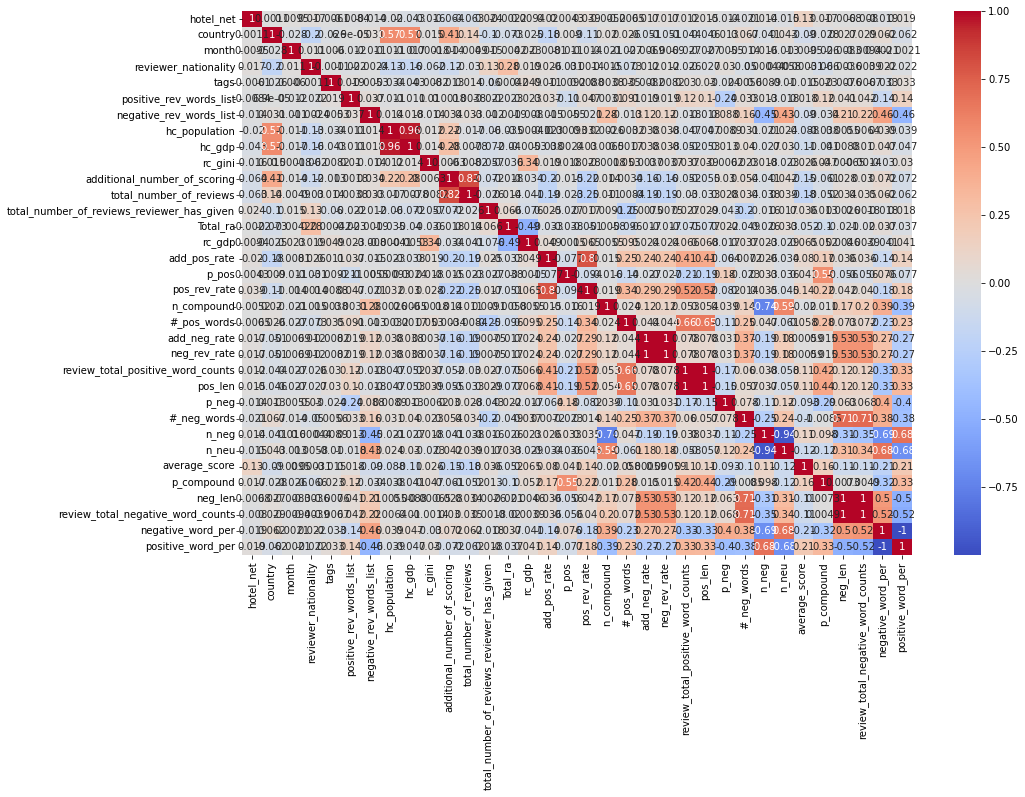

In [67]:
%%time

plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(train_data.drop(TARGET_NAME,axis=1).corr(), annot=True, cmap='coolwarm')

In [68]:
# Уберем признаки с мультикорреляцией
drop_col = ['hc_population','total_number_of_reviews','add_pos_rate','neg_rev_rate','review_total_positive_word_counts','n_neg','neg_len','positive_word_per']

train_data.drop(drop_col,axis=1,inplace=True)
test_data.drop(drop_col,axis=1,inplace=True)

Wall time: 1.24 s


<AxesSubplot:>

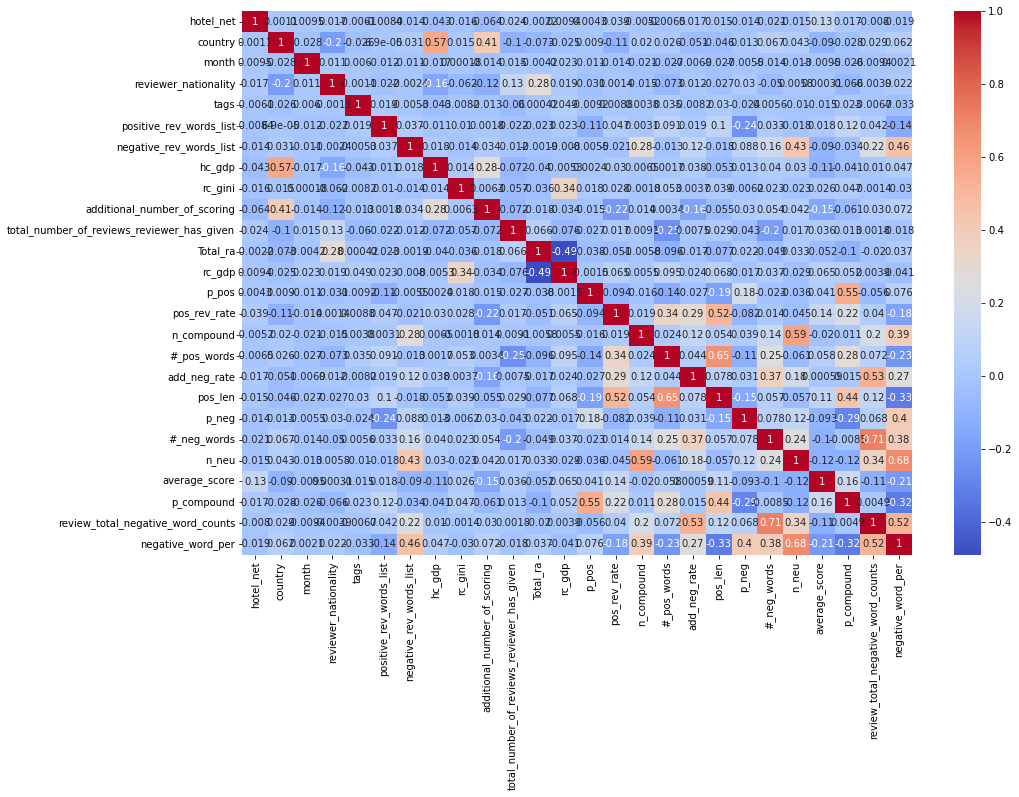

In [69]:
%%time
# Проверим оставшиеся признаки
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(train_data.drop(TARGET_NAME,axis=1).corr(), annot=True, cmap='coolwarm')

# Подготавливаем модель и обучаем ее

Воспользуемся framework'ом от группы Сбера [LightAutoML](https://github.com/sberbank-ai-lab/LightAutoML).

## Подготовка и обучение

In [70]:
# Разедлим данные для обучения и самопроверки
tr_data, te_data = train_test_split(
    train_data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (309196, 27), te_data = (77300, 27)


,reviewer_score,hotel_net,country,month,reviewer_nationality,tags,positive_rev_words_list,negative_rev_words_list,hc_gdp,rc_gini,...,#_pos_words,add_neg_rate,pos_len,p_neg,#_neg_words,n_neu,average_score,p_compound,review_total_negative_word_counts,negative_word_per
id,,,,,,,,,,,,,,,,,,,,,
59437,7.5,5.0,5.0,4,3.0,3.0,9.0,12.0,2.759804e+12,35.1,...,1.0,0.023928,25,0.0,6.0,0.819,8.2,0.0000,24,85.714286
372149,9.2,5.0,5.0,10,3.0,44.0,2.0,6.0,2.759804e+12,35.1,...,16.0,0.016529,108,0.0,28.0,0.844,9.3,0.9599,28,63.636364
74398,8.3,3.0,5.0,7,5.0,80.0,4.0,12.0,2.759804e+12,31.9,...,79.0,0.007502,388,0.0,17.0,0.838,8.2,0.9781,17,17.708333
69311,7.9,5.0,1.0,11,5.0,60.0,3.0,5.0,2.630318e+12,33.3,...,13.0,0.034738,150,0.0,23.5,0.802,8.3,0.9300,47,64.383562
357939,9.6,5.0,1.0,11,5.0,42.0,5.0,0.0,2.630318e+12,63.0,...,11.0,0.000000,130,0.0,0.0,0.000,7.9,0.9325,0,0.000000


In [71]:
# Зададим для LAMA задание и определим роли
task = Task('reg', loss = 'mape')

roles = {
    'target': TARGET_NAME,
}

In [72]:
# Инициализация начальных данных
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

In [73]:
%%time
# Обучение модели
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

[09:43:55] Stdout logging level is INFO.
[09:43:55] Task: reg

[09:43:55] Start automl preset with listed constraints:
[09:43:55] - time: 2400.00 seconds
[09:43:55] - CPU: 8 cores
[09:43:55] - memory: 16 GB

[09:43:55] Train data shape: (309196, 27)

[09:44:03] Layer 1 train process start. Time left 2392.07 secs
[09:44:22] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[09:44:37] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -1.4432180918672046
[09:44:37] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[09:44:37] Time left 2357.74 secs

[09:47:56] Selector_LightGBM fitting and predicting completed
[09:48:16] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[09:50:47] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1.3033816005623715
[09:50:47] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[09:50:47] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[09:56:21] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -1.3618803057506381
[09:56:21] Lvl_0_Pi

In [74]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.11770 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.56237 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.31993 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


## Проверим себя на выделенном диапозоне для самопроверки

In [75]:
%%time

te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[9.566275],
       [9.500452],
       [9.561511],
       ...,
       [9.517065],
       [9.083229],
       [6.251174]], dtype=float32)
Shape = (77300, 1)
Wall time: 7.16 s


In [76]:
print(f'MAPE score: {mean_absolute_percentage_error(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

MAPE score: 0.11906807585917631


## Итоги

### Удалось достачь хорошей точности предсказания рейтинга по спроектированным признакам **11.89%**

# Посмотрим итоговый вклад признаков в предсказательную модель

Wall time: 87.5 ms


<AxesSubplot:xlabel='Feature'>

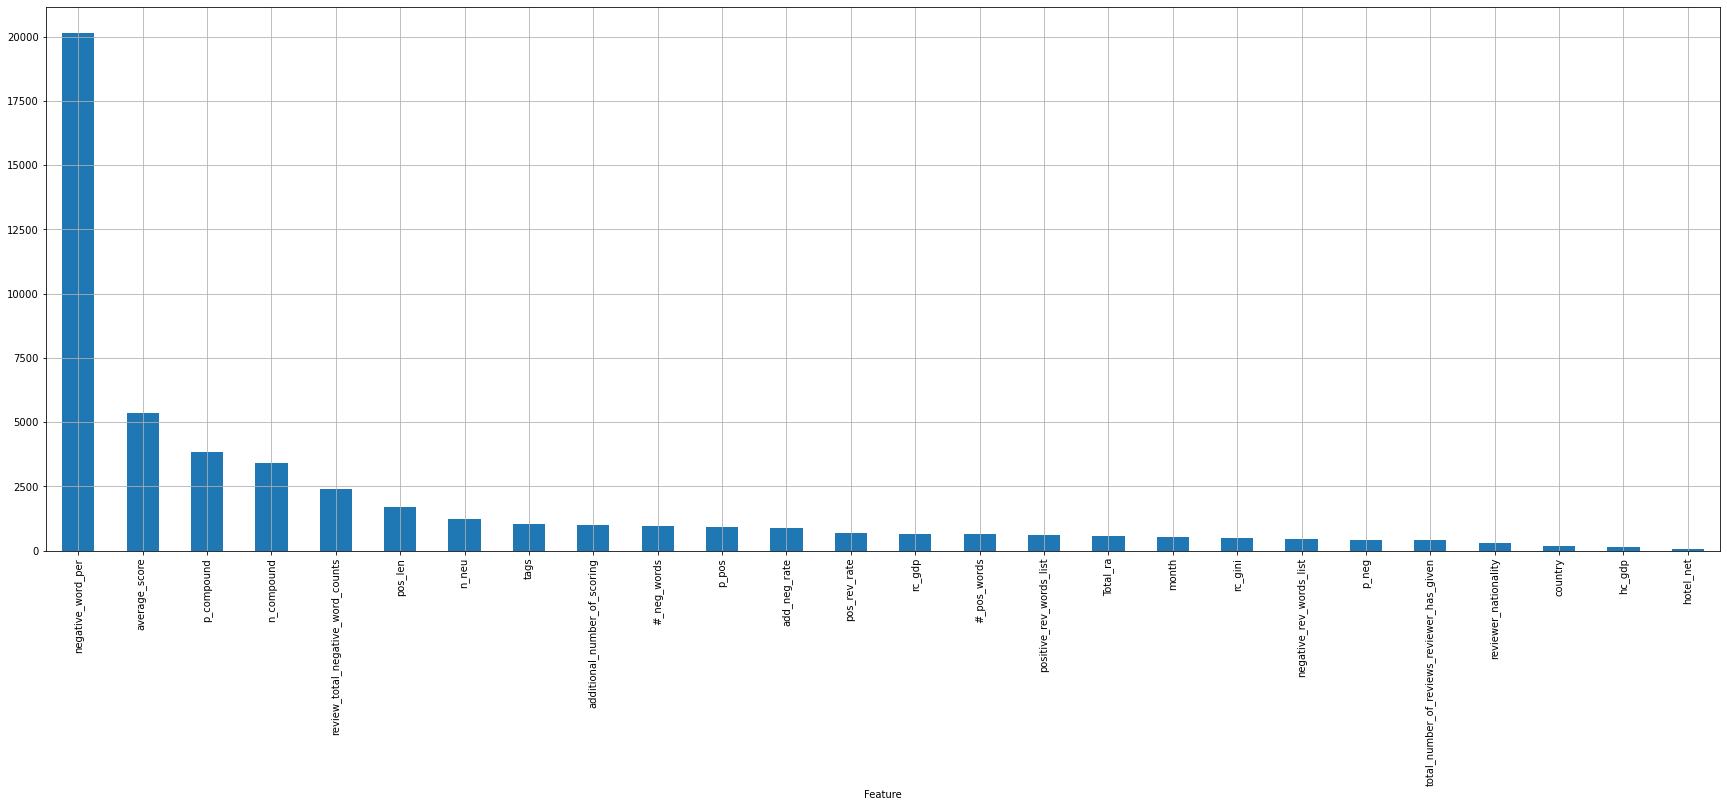

In [77]:
%%time

# Быстрый расчет влияния признаков
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

Wall time: 2min 57s


<AxesSubplot:xlabel='Feature'>

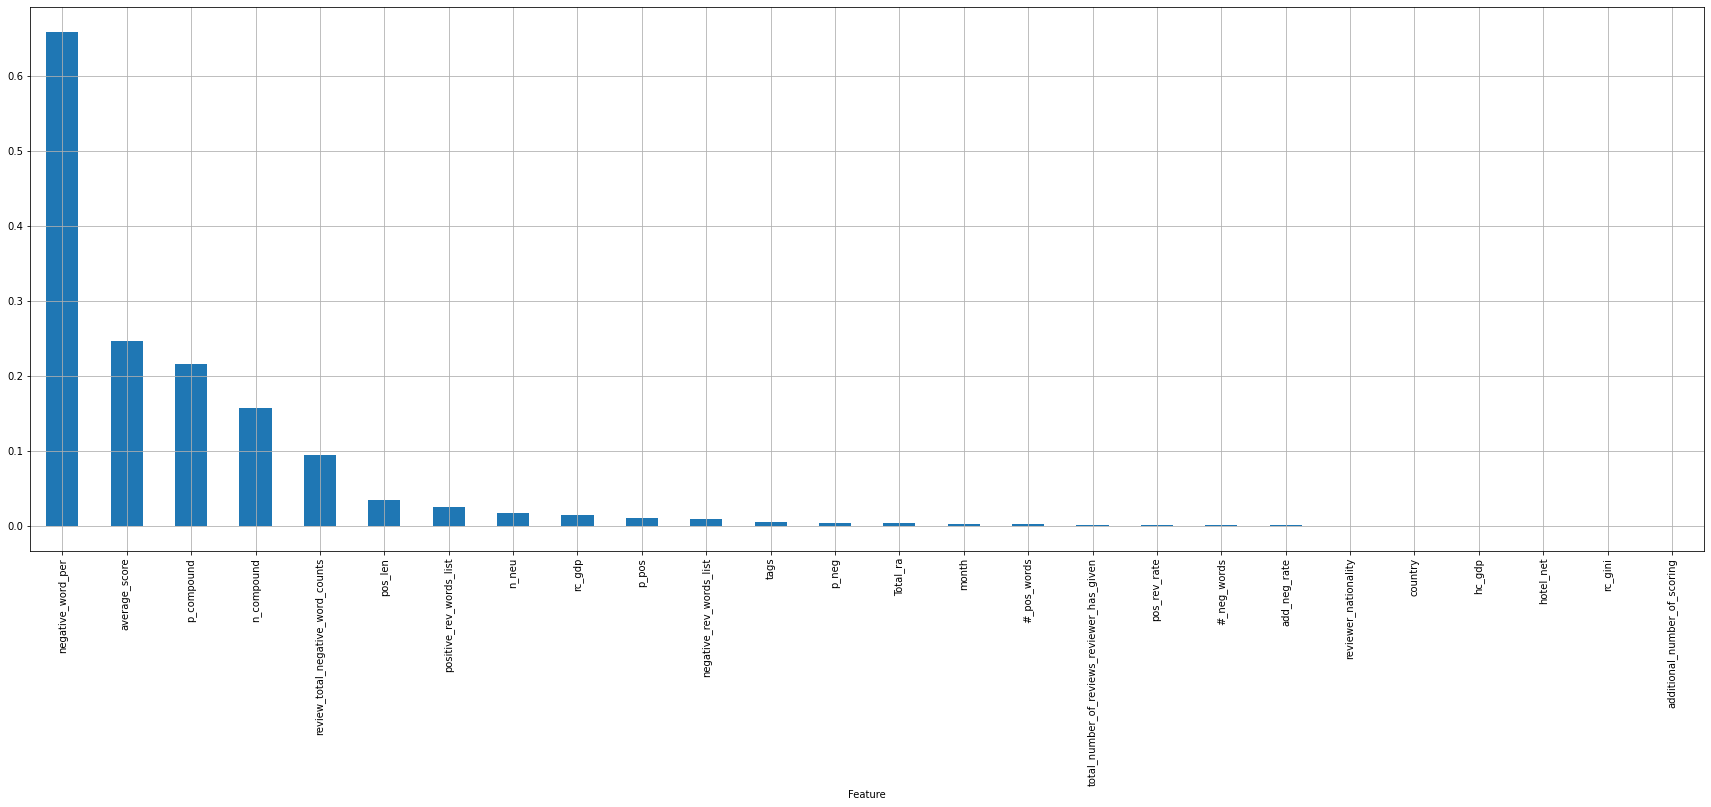

In [78]:
%%time

# Более точный расчет влияния признаков
accurate_fi = automl.get_feature_scores('accurate', te_data, silent = False)
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# Сделаем предсказание на целевых данных

In [79]:
test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

Prediction for te_data:
array([[8.860519],
       [7.724634],
       [8.334077],
       ...,
       [8.133749],
       [9.819442],
       [7.261033]], dtype=float32)
Shape = (128935, 1)


In [80]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128935 entries, 0 to 128934
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_net                                   128935 non-null  float64
 1   country                                     128935 non-null  float64
 2   month                                       128935 non-null  int64  
 3   reviewer_nationality                        128935 non-null  float64
 4   tags                                        128935 non-null  float64
 5   positive_rev_words_list                     128935 non-null  float64
 6   negative_rev_words_list                     128935 non-null  float64
 7   hc_gdp                                      128935 non-null  float64
 8   rc_gini                                     128935 non-null  float64
 9   additional_number_of_scoring                128935 non-null  int64  
 

In [81]:
submission = pd.read_csv('data\submission.csv')
print(submission.shape)
submission.head()

(128935, 2)


,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [82]:
submission[TARGET_NAME] = test_pred.data
submission.to_csv('data\output\lightautoml_tabularautoml_mape.csv', index = False)

In [83]:
submission.head()

,reviewer_score,id
0,8.860519,488440
1,7.724634,274649
2,8.334077,374688
3,9.898201,404352
4,9.813129,451596


# Выводы:
* Отработаны навыки очистки и анализа данных
* Отработаны навыки проектирования признаков на реальном кейсе
* Получены начальные навыки обращения с машинным обучением
* Получен хороший результат обучения (среднее процентное отклонение составило **11,89%**)